# compare random population, ga result and validation test dataset

In [1]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

import ast
import itertools
import math
import random
import time
from math import comb
from statistics import variance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from deap import algorithms, base, creator, tools
from ga import not_dup, rand_nodup
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import norm
from tqdm import tqdm
from util import pickle_load, robust_z

In [2]:
# validation test name
test_num = "0905"
ligand = "anta"
date = 241219
num = 1

In [ ]:
trys = str(date) + "_" + str(num)

if ligand in ["ago", "anta"]:
    test_name = test_num + "_" + ligand
else:
    test_name = test_num
    
lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")

scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)

In [14]:
all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

if len(set(all_toxs)) == 2:
    tox_scoring = "descrete"
else:
    tox_scoring = "continuous"

if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "descrete":
    standardized_toxs = all_toxs

def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

In [5]:
tox_r_fp = []
bussei_r_fp = []
tani_r_fp = [] 

count = 0
IND_INIT_SIZE = len(val)

now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime), flush=True)

while count < 10000:
    if count == 10:
        now = time.ctime()
        strtime = time.strptime(now)
        print(time.strftime("%Y/%m/%d %H:%M", strtime), flush=True)
    if count % 1000 == 0 and count != 0:
        now = time.ctime()
        strtime = time.strptime(now)
        print(f"--------{count}--------")
        print(time.strftime("%Y/%m/%d %H:%M", strtime), flush=True)
    a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
    a = set(a)
    while len(a) != IND_INIT_SIZE:
        a.add(random.randint(0, len(cas_tox)-1))
    score_moo = multi_objective_optimization(a)
    tox_r_fp.append(score_moo[2])
    bussei_r_fp.append(score_moo[1])
    tani_r_fp.append(score_moo[0])
    count += 1

2024/12/30 16:38
2024/12/30 16:38
--------1000--------
2024/12/30 16:38
--------2000--------
2024/12/30 16:38
--------3000--------
2024/12/30 16:38
--------4000--------
2024/12/30 16:38
--------5000--------
2024/12/30 16:38
--------6000--------
2024/12/30 16:38
--------7000--------
2024/12/30 16:38
--------8000--------
2024/12/30 16:38
--------9000--------
2024/12/30 16:38


In [7]:
val_cas = []
val_toxs = []
for i in range(len(val)):
    val_cas.append(val.iloc[i,0])
    val_toxs.append(val.iloc[i,1])

if len(set(val_toxs)) == 2:
    tox_scoring = "descrete"
else:
    tox_scoring = "continuous"

if tox_scoring == "continuous":
    standardized_toxs_val = robust_z(val_toxs)
elif tox_scoring == "descrete":
    standardized_toxs_val = val_toxs

def multi_objective_optimization_val(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs_val[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = val_lookup[f"{val_cas[t[i][0]]}, {val_cas[t[i][1]]}"]
        except:
            dict_t = val_lookup[f"{val_cas[t[i][1]]}, {val_cas[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

val_num = [i for i in range(len(val))]
val_score = multi_objective_optimization_val(val_num)

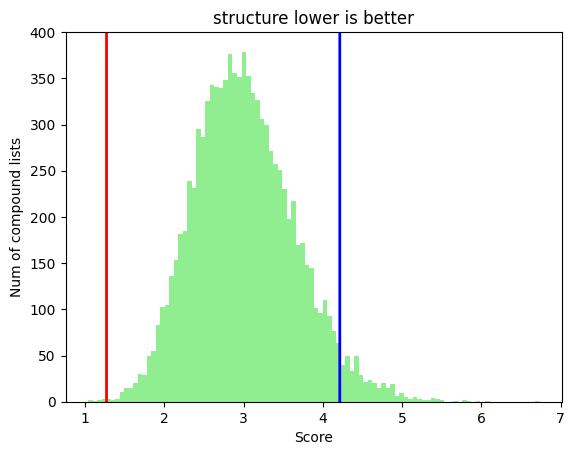

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

y = np.arange(0, 600, 0.5)

x = []
for i in range(len(y)):
    x.append(scores.iloc[-1,0])

x_1 = []
for i in range(len(y)):
    x_1.append(val_score[0])

ax.hist(tani_r_fp, bins=100, color="lightgreen")
ax.set_title('structure lower is better')
ax.set_xlabel('Score')
ax.set_ylabel('Num of compound lists')

ax.set_ylim(0,400)
ax.plot(x, y, '-', linewidth=2, color="red")
ax.plot(x_1, y, '-', linewidth=2, color="blue")
fig.show()
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/structure_comp_random.png")

(array([3.000e+01, 1.660e+02, 5.300e+02, 1.099e+03, 1.441e+03, 1.521e+03,
        1.343e+03, 1.039e+03, 7.750e+02, 5.660e+02, 3.440e+02, 3.010e+02,
        2.120e+02, 1.490e+02, 1.020e+02, 9.000e+01, 6.600e+01, 5.300e+01,
        3.100e+01, 1.600e+01, 2.400e+01, 2.300e+01, 2.300e+01, 1.700e+01,
        1.400e+01, 5.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.69142591, 0.8773723 , 1.06331868, 1.24926507, 1.43521145,
        1.62115784, 1.80710423, 1.99305061, 2.178997  , 2.36494338,
        2.55088977, 2.73683616, 2.92278254, 3.10872893, 3.29467531,
        3.4806217 , 3.66656809, 3.85251447, 4.03846086, 4.22440724,
        4.41035363, 4.59630002, 4.7822464 , 4.96819279, 5.15413917,
        5.34008556, 5.52603195, 5.71

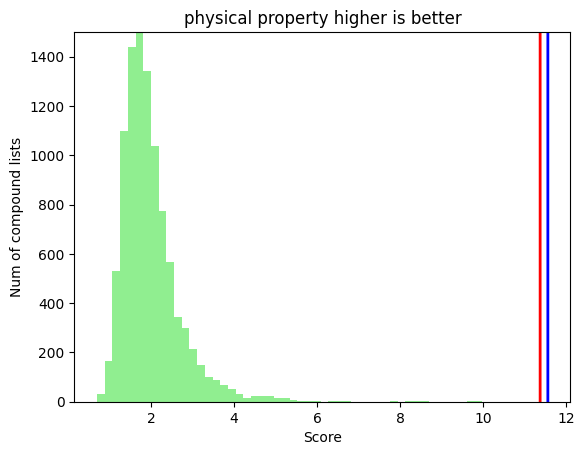

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

y = np.arange(0, 1500, 0.5)

x = []
for i in range(len(y)):
    x.append(scores.iloc[-1,2])

x_1 = []
for i in range(len(y)):
    x_1.append(val_score[1])

ax.set_title('physical property higher is better')
ax.set_xlabel('Score')
ax.set_ylabel('Num of compound lists')

ax.set_ylim(0, 1500)
ax.plot(x, y, '-', linewidth=2, color="red")
ax.plot(x_1, y, '-', linewidth=2, color="blue")
fig.show()
plt.hist(bussei_r_fp, bins=50, color="lightgreen")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/physical_property_comp_random.png")

Counter({-1.807507826196194: 2871, -2.6548056865833978: 2696, -1.4020427180880297: 2322, -4.041100047703289: 1652, -6.238324625039508: 459})


<BarContainer object of 5 artists>

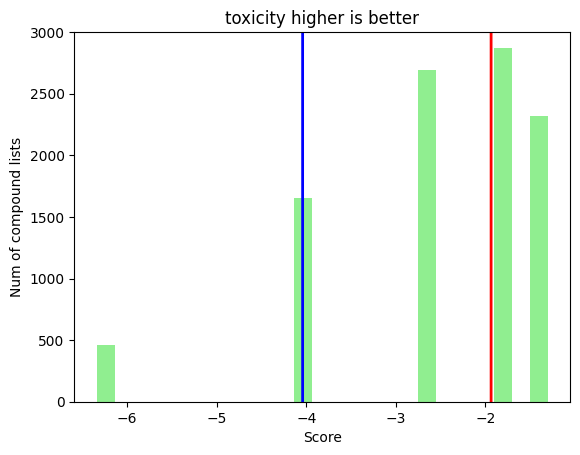

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

y = np.arange(0, 3000, 0.5)

x = []
for i in range(len(y)):
    x.append(scores.iloc[-1,4])

x_1 = []
for i in range(len(y)):
    x_1.append(val_score[2])

import collections
c = collections.Counter(tox_r_fp)
print(c)
ax.set_title('toxicity higher is better')
ax.set_xlabel('Score')
ax.set_ylabel('Num of compound lists')

ax.set_ylim(0, 3000)
ax.plot(x, y, '-', linewidth=2, color="red")
ax.plot(x_1, y, '-', linewidth=2, color="blue")
fig.show()
plt.bar(list(c.keys()), list(c.values()), width=0.2, color="lightgreen")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/toxicity_comp_random.png")

# Run all tests at the same time (only validation dataset)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [06:41<00:00, 44.58s/it]


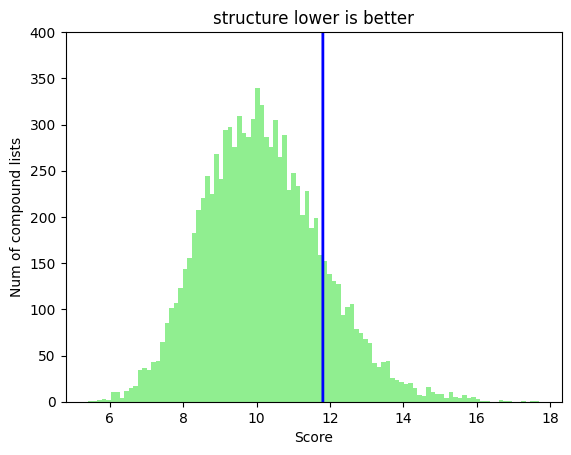

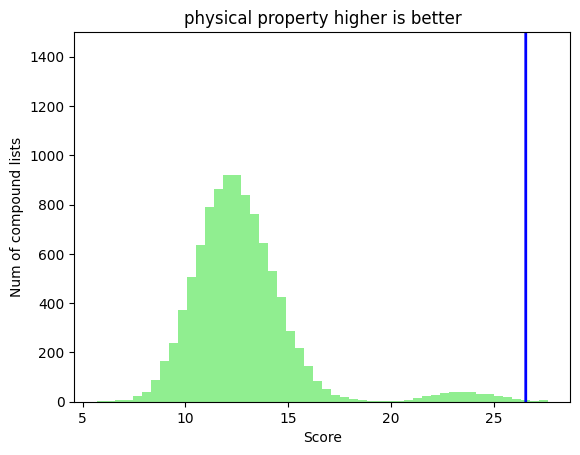

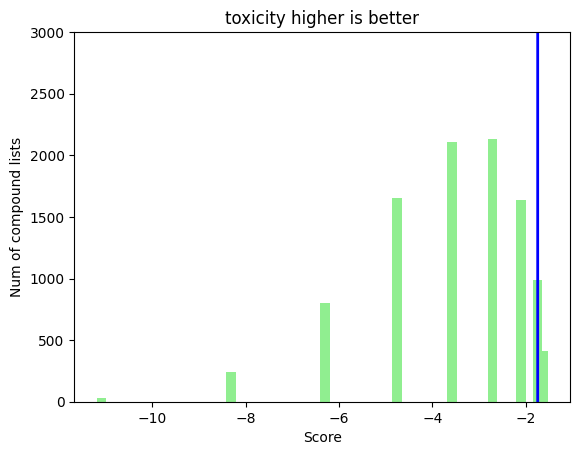

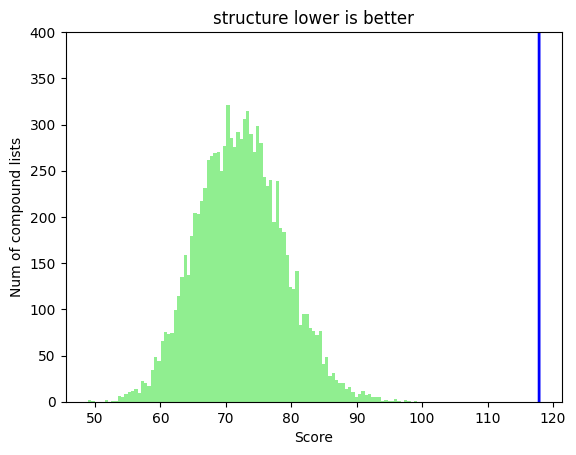

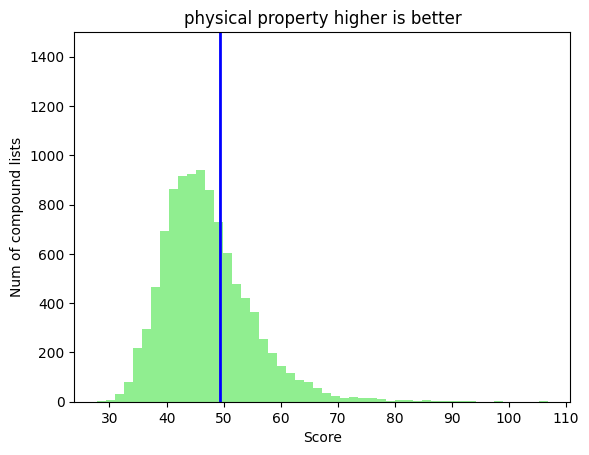

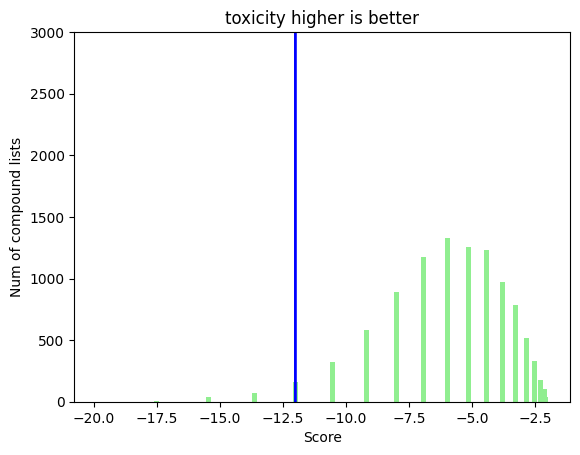

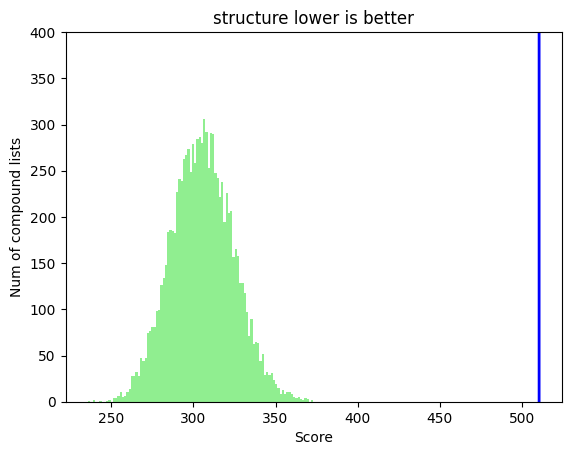

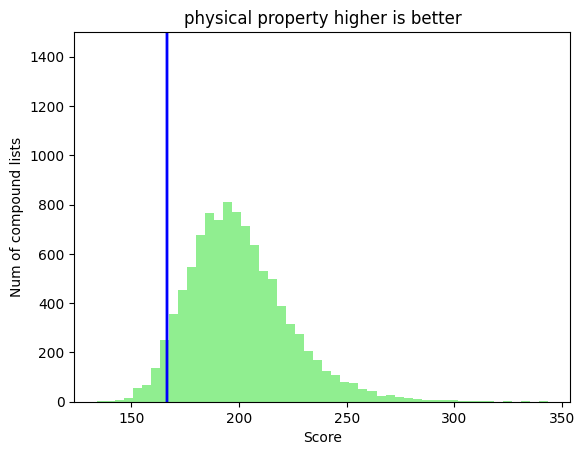

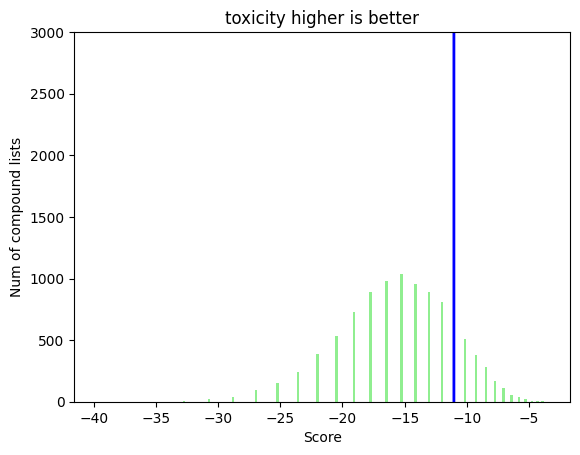

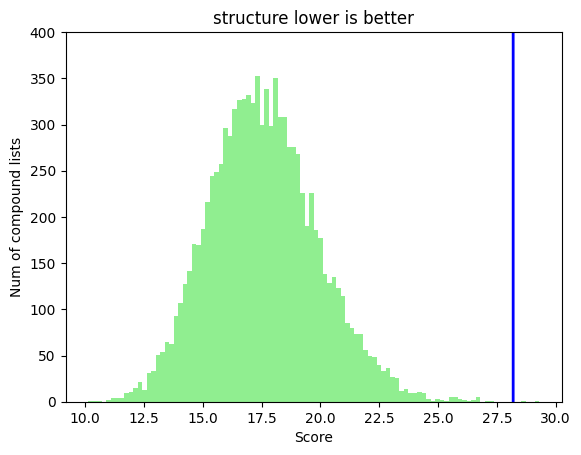

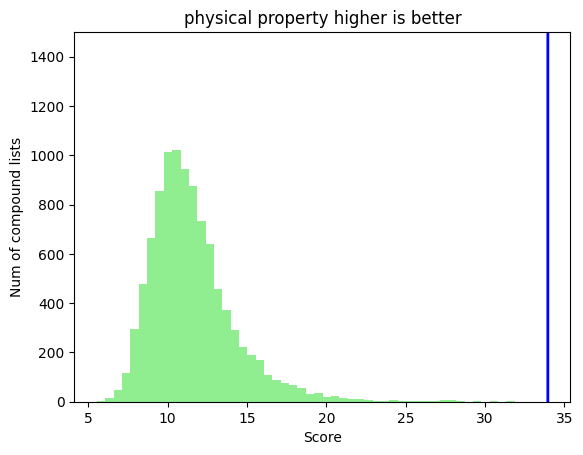

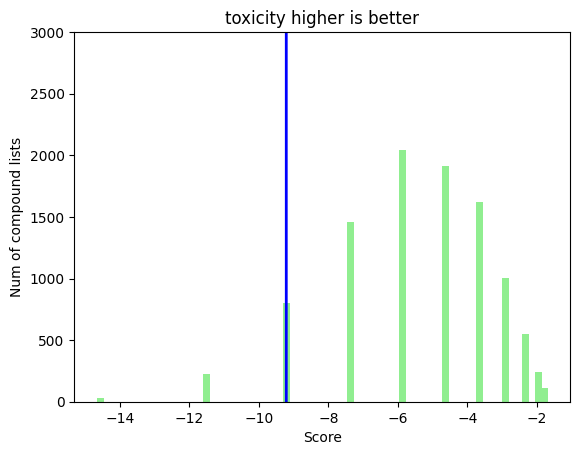

In [6]:
import collections
for test_num in tqdm(["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]):
    for lig in ["ago", "anta"]:

        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        date = 241219
        num = 1
        
        trys = str(date) + "_" + str(num)
        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num
        
        if test_name not in ["0901_ago", "0902_ago", "0902_anta", "1002"]:
            continue
        
        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
        val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")
        scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)
        
        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_cas = []
        val_toxs = []
        for i in range(len(val)):
            val_cas.append(val.iloc[i,0])
            val_toxs.append(val.iloc[i,1])

        if len(set(val_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs_val = robust_z(val_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs_val = val_toxs

        def multi_objective_optimization_val(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs_val[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = val_lookup[f"{val_cas[t[i][0]]}, {val_cas[t[i][1]]}"]
                except:
                    dict_t = val_lookup[f"{val_cas[t[i][1]]}, {val_cas[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_num = [i for i in range(len(val))]
        val_score = multi_objective_optimization_val(val_num)

        tox_r_fp = []
        bussei_r_fp = []
        tani_r_fp = [] 

        count = 0
        IND_INIT_SIZE = len(val)

        while count < 10000:
            a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
            a = set(a)
            while len(a) != IND_INIT_SIZE:
                a.add(random.randint(0, len(cas_tox)-1))
            score_moo = multi_objective_optimization(a)
            tox_r_fp.append(score_moo[2])
            bussei_r_fp.append(score_moo[1])
            tani_r_fp.append(score_moo[0])
            count += 1

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 600, 0.5)
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[0])

        ax.hist(tani_r_fp, bins=100, color="lightgreen")
        ax.set_title('structure lower is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0,400)
        ax.plot(x_1, y, '-', linewidth=2, color="blue")
        fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/structure_comp_random_only_val.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 1500, 0.5)
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[1])

        ax.set_title('physical property higher is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0, 1500)
        ax.plot(x_1, y, '-', linewidth=2, color="blue")
        fig.show()
        plt.hist(bussei_r_fp, bins=50, color="lightgreen")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/physical_property_comp_random_only_val.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 3000, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,4])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[2])

        if tox_scoring == "descrete":
            c = collections.Counter(tox_r_fp)
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x_1, y, '-', linewidth=2, color="blue")
            plt.bar(list(c.keys()), list(c.values()), width=0.2, color="lightgreen")
            fig.show()
        elif tox_scoring == "continuous":
            plt.hist(tox_r_fp, bins=50, color="lightgreen")
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x_1, y, '-', linewidth=2, color="blue")
            fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/toxicity_comp_random_only_val.png")

In [5]:
for test_num in tqdm(["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]):
    for lig in ["ago", "anta"]:

        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        date = 241219
        num = 1
        
        trys = str(date) + "_" + str(num)
        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num

        date = 241219
        num = 1
        
        trys = str(date) + "_" + str(num)
        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num
        
        if os.path.exists(f"../../data/result/{test_name}/GA_{trys}/structure_comp_random_only_val.png"):
            continue
        else:
            print(f"../../data/result/{test_name}/GA_{trys}/structure_comp_random_only_val.png")

100%|██████████| 9/9 [00:00<00:00, 19191.02it/s]


# Run all tests at the same time

100%|██████████| 9/9 [07:41<00:00, 51.32s/it]


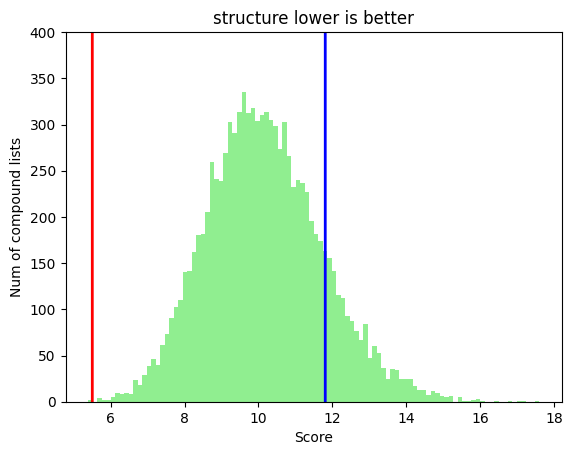

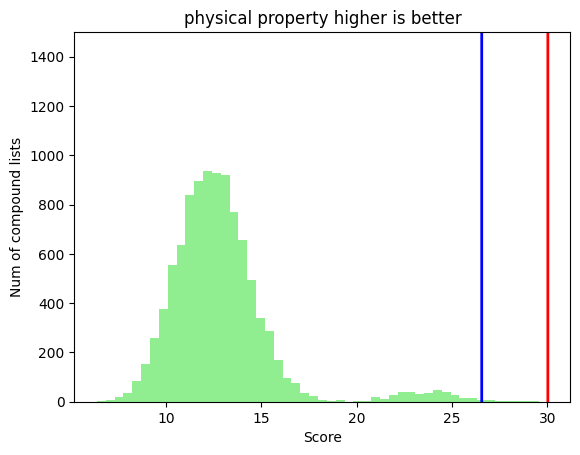

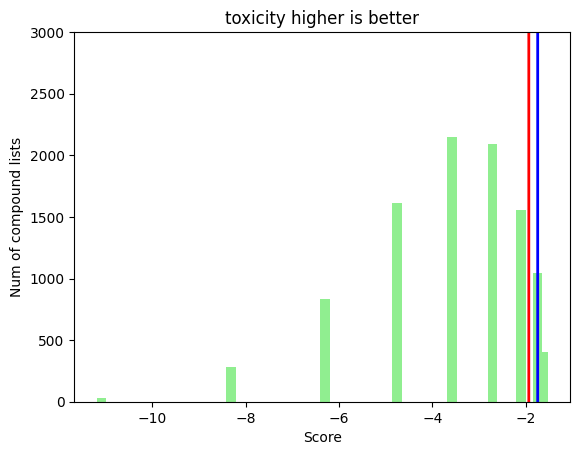

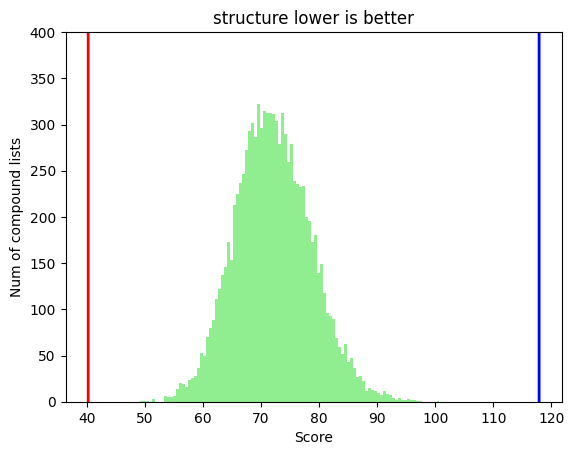

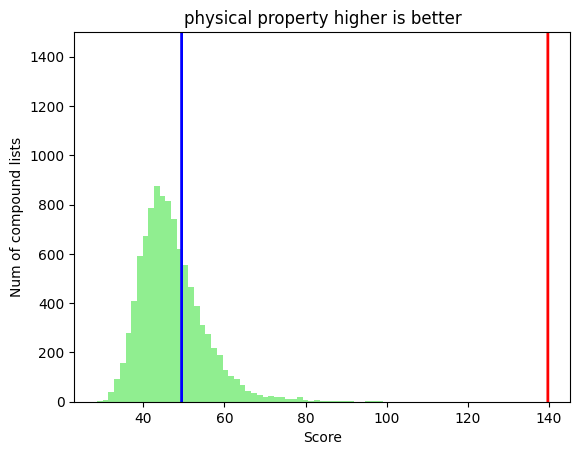

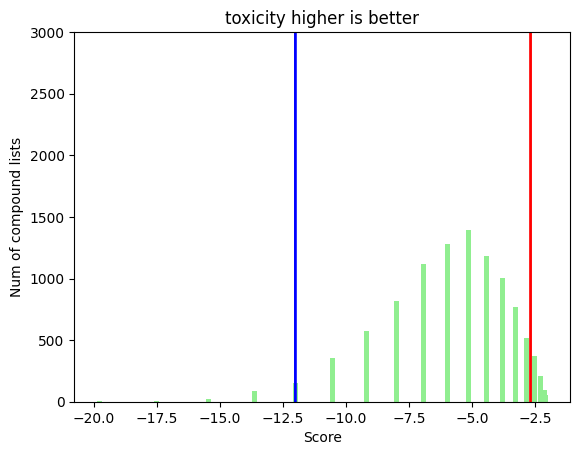

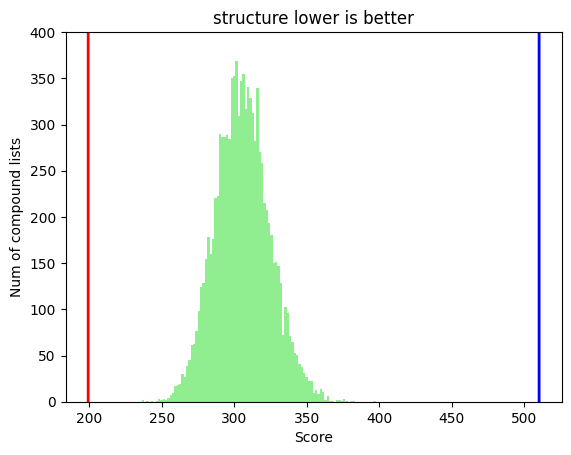

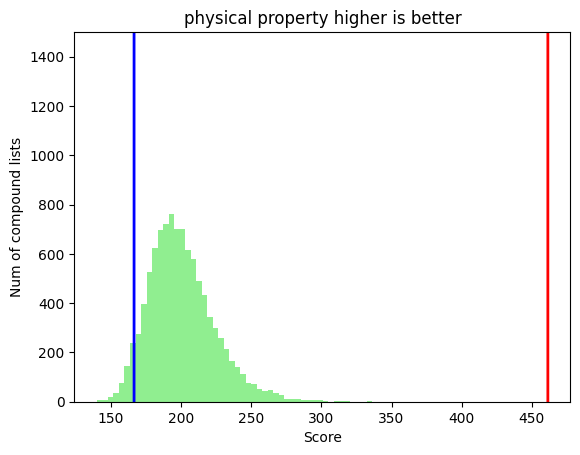

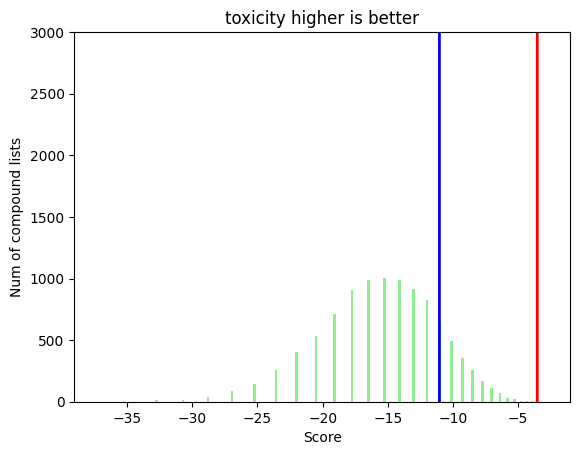

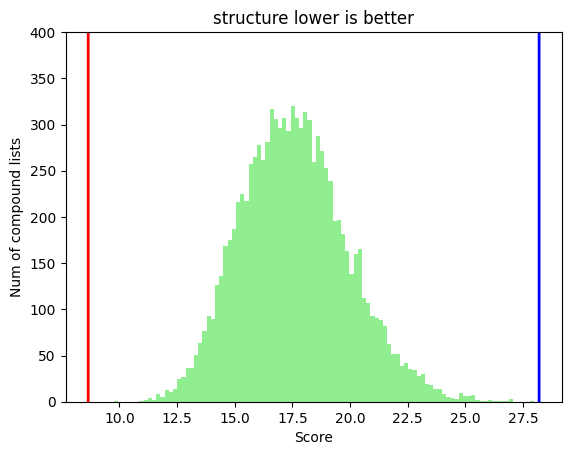

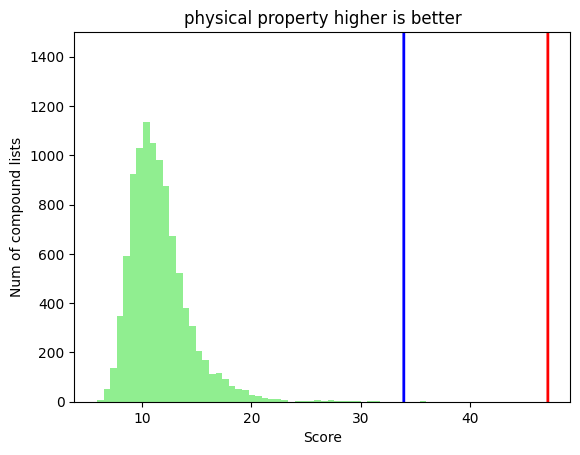

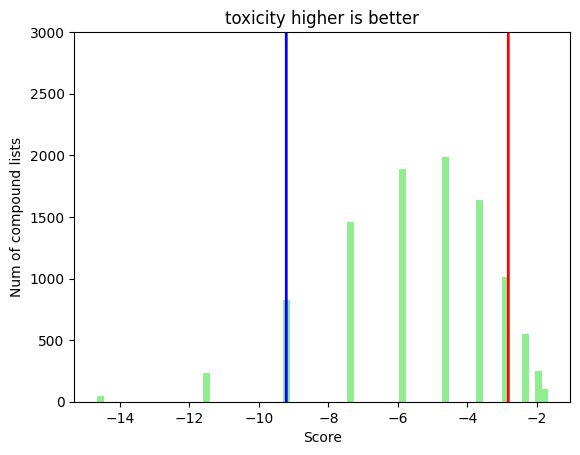

In [7]:
import collections
for test_num in tqdm(["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]):
    for lig in ["ago", "anta"]:

        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        date = 241219
        num = 1
        
        trys = str(date) + "_" + str(num)
        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num
        
        if test_name not in ["0901_ago", "0902_ago", "0902_anta", "1002"]:
            continue
        
        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
        val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")
        scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)
        
        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_cas = []
        val_toxs = []
        for i in range(len(val)):
            val_cas.append(val.iloc[i,0])
            val_toxs.append(val.iloc[i,1])

        if len(set(val_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs_val = robust_z(val_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs_val = val_toxs

        def multi_objective_optimization_val(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs_val[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = val_lookup[f"{val_cas[t[i][0]]}, {val_cas[t[i][1]]}"]
                except:
                    dict_t = val_lookup[f"{val_cas[t[i][1]]}, {val_cas[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        val_num = [i for i in range(len(val))]
        val_score = multi_objective_optimization_val(val_num)

        tox_r_fp = []
        bussei_r_fp = []
        tani_r_fp = [] 

        count = 0
        IND_INIT_SIZE = len(val)

        while count < 10000:
            a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
            a = set(a)
            while len(a) != IND_INIT_SIZE:
                a.add(random.randint(0, len(cas_tox)-1))
            score_moo = multi_objective_optimization(a)
            tox_r_fp.append(score_moo[2])
            bussei_r_fp.append(score_moo[1])
            tani_r_fp.append(score_moo[0])
            count += 1

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 600, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,0])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[0])

        ax.hist(tani_r_fp, bins=100, color="lightgreen")
        ax.set_title('structure lower is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0,400)
        ax.plot(x, y, '-', linewidth=2, color="red")
        ax.plot(x_1, y, '-', linewidth=2, color="blue")
        fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/structure_comp_random.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 1500, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,2])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[1])

        ax.set_title('physical property higher is better')
        ax.set_xlabel('Score')
        ax.set_ylabel('Num of compound lists')
        ax.set_ylim(0, 1500)
        ax.plot(x, y, '-', linewidth=2, color="red")
        ax.plot(x_1, y, '-', linewidth=2, color="blue")
        fig.show()
        plt.hist(bussei_r_fp, bins=50, color="lightgreen")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/physical_property_comp_random.png")

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        y = np.arange(0, 3000, 0.5)
        x = []
        for i in range(len(y)):
            x.append(scores.iloc[-1,4])
        x_1 = []
        for i in range(len(y)):
            x_1.append(val_score[2])

        if tox_scoring == "descrete":
            c = collections.Counter(tox_r_fp)
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x, y, '-', linewidth=2, color="red")
            ax.plot(x_1, y, '-', linewidth=2, color="blue")
            plt.bar(list(c.keys()), list(c.values()), width=0.2, color="lightgreen")
            fig.show()
        elif tox_scoring == "continuous":
            plt.hist(tox_r_fp, bins=50, color="lightgreen")
            ax.set_title('toxicity higher is better')
            ax.set_xlabel('Score')
            ax.set_ylabel('Num of compound lists')
            ax.set_ylim(0, 3000)
            ax.plot(x, y, '-', linewidth=2, color="red")
            ax.plot(x_1, y, '-', linewidth=2, color="blue")
            fig.show()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/toxicity_comp_random.png")